In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import sqlite3 as sql
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import datetime as dt
# import geopandas as gpd
# import plotly_express as px
images_dir = '/content/gdrive/MyDrive/Bike/Images'   

def resample_bike_data_for_missing_timestamps(bike_data):
  bike_data = bike_data.set_index(['time'])
  bike_data = bike_data.groupby('station_id').resample('5min',offset='3s').first().ffill().reset_index(level=0, drop=True)
  return bike_data.reset_index()


def read_bike_weather_data(bike_data ,weather_data = '/content/gdrive/MyDrive/Bike/hly175.csv'):
  bike_data = pd.read_csv(bike_data, usecols=['STATION ID', 'TIME', 'NAME', 'BIKE STANDS',
       'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'ADDRESS',
       'LATITUDE', 'LONGITUDE'])
  bike_data['TIME'] = pd.to_datetime(bike_data['TIME'])
  bike_data = bike_data.set_index(['TIME'])
  weather_data = pd.read_csv(weather_data,header=12, skiprows=range(16, 140000),  usecols=['date', 'rain', 'temp'])
  bike_data = bike_data.reset_index()
  
  bike_data['TIME'] = pd.to_datetime(bike_data['TIME'])
  
  bike_data.drop(bike_data[bike_data['STATION ID'] > 200].index, inplace=True)
  bike_data.rename(columns={'STATION ID': 'station_id', 'TIME': 'time','NAME' : 'name','BIKE STANDS':'bike_stands','AVAILABLE BIKE STANDS':'available_bike_stands',
                            'AVAILABLE BIKES':'available_bikes','ADDRESS':'address','LATITUDE':'latitude',
                            'LONGITUDE':'longitude'}, inplace=True)
  return bike_data, weather_data

def merge_bike_weather_data(bike_data, weather_data):
  first_bike_timestamp = bike_data['time'].min()
  last_bike_timestamp = bike_data['time'].max()

  weather_data['date'] = pd.to_datetime(weather_data['date'])
  weather_data = weather_data.sort_values('date')
  weather_data = weather_data[(weather_data['date']>= pd.to_datetime(first_bike_timestamp)) & (weather_data['date'] <= pd.to_datetime(last_bike_timestamp))]

  bike_data.index = bike_data['time']
  
  weather_data.index = weather_data['date']
  tol = pd.Timedelta('1 hour')
  bike_data = bike_data.sort_index()

  df = pd.merge_asof(left=bike_data,right=weather_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)
  df = df.set_index('time')

  return df


def print_timestamps_info(data):
  data = data.reset_index()
  print('No. of unique timestamps: ', data['time'].unique().shape[0], '\nNo. of Timestamps: ' ,data['time'].shape[0])
  print('% unique timestamps: ' ,data['time'].unique().shape[0]/data['time'].shape[0]*100, '%')
  print('No. Times timestamps repeated: ' ,data['time'].shape[0]/data['time'].unique().shape[0])
  print('No. of  Stations: ', data['STATION ID'].nunique())
  print('First timestamp is: ', data['time'].min())
  print('Last timestamp is: ', data['time'].max())



def print_summary_statistics(data):
  print(data.info())
  print(data.describe(datetime_is_numeric=True))
  print('\nNo. of missing values overall: ', data.isna().sum())

def print_weather_summary(data):
  print("\nAverage temp. across the months included:\n", data.groupby(data['time'].dt.month)['temp'].mean())
  print("\nHighest temp. across the months included:\n", data.groupby(data['time'].dt.month)['temp'].max())
  print("\nLowest temp. across the months included:\n", data.groupby(data['time'].dt.month)['temp'].min())
  print("\nAverage rain. across the months included:\n", data.groupby(data['time'].dt.month)['rain'].mean())
  print("\nHighest rain. across the months included:\n", data.groupby(data['time'].dt.month)['rain'].max())
  print("\nLowest rain. across the months included:\n", data.groupby(data['time'].dt.month)['rain'].min())  


def add_columns_for_active_and_decomissioned_bikes_and_station_availability(data):
  
  # Making assumption that the remainder after subtracting (available bikes + available stands) from No. Bike stands is the no. of bikes currently not in comission
  #data.drop('TIME',inplace=True,axis='columns')
  data.reset_index()
  data['decomissioned'] = (data['bike_stands'] - (data['available_bike_stands'] + data['available_bikes']))
  data = data.groupby(['time','station_id']).first().reset_index()

  # Creating a pivot table to show the no. of bikes available at each station at each timestamp
  # Creating a pivot table to show the no. of bikes not in comission at each station at each timestamp

  stationsAvailable = data.pivot(index='time', columns = 'station_id', values='available_bikes')
  stationsDecomission = data.pivot(index='time', columns = 'station_id', values='decomissioned')

  # Calculating the sum for each of the above across all stations (total no. available and total no. decomissioned across entire station network)

  available_bikes = stationsAvailable.sum(axis=1).reset_index()
  decomissioned = stationsDecomission.sum(axis=1).reset_index()
  available_bikes.columns = ['time','available_bikes']
  decomissioned.columns = ['time','decomissioned_bikes']

  # Calculating the max no. of available bikes across the entire network for any given day - making assumption that this is the total no. available bikes

  max_available = available_bikes.set_index('time')['available_bikes'].resample('24 H').max()

  data['date'] = pd.to_datetime(data['time'].dt.date)
  data = pd.merge_asof(left=data,right=max_available, right_index=True, left_on= 'date' )
  data.rename(columns={'available_bikes_y': 'available_bikes_max', 'available_bikes_x' : 'available_bikes_at_station'}, inplace=True)
  data = pd.merge_asof(left=data,right=available_bikes, right_on='time', left_on= 'time')

  # Making the assumption that the no. of bikes currently in use is equal to the difference between the total no. available and the current no. available

  data['active_bikes'] = data['available_bikes_max'] - data['available_bikes']

  max_available_per_station24hr = data.groupby([data['time'].dt.date,'station_id'])['available_bikes_at_station'].max()
  max_available_per_station24hr = max_available_per_station24hr.reset_index()
  max_available_per_station24hr['time'] = pd.to_datetime(max_available_per_station24hr['time'])

  max_available_per_station24hr['station_id'] = max_available_per_station24hr['station_id'].astype("int32")
  data['station_id'] = data['station_id'].astype("int32")
  data = pd.merge_asof(left=data,right=max_available_per_station24hr, right_on='time', left_on= 'date', by='station_id')
  data.drop(columns=['date','time_y'], inplace=True)
  data.rename(columns={'available_bikes_at_station_x': 'available_bikes_at_station', 'available_bikes_at_station_y': 'available_bikes_at_station_max', 'time_x' : 'time'}, inplace=True)

  # Creating a column to indicate the availability of bikes at each timestamp as a percentage of the maximum number avaialble during that day (as a percentage)

  data['station_availability'] = data['available_bikes_at_station']/data['available_bikes_at_station_max']*100
  data = data.fillna(0)
  data['rainy_day'] = data['rain'] > 0  

  return data

def add_time_of_day_label(time):
  hr = time.hour
  if (hr >= 0 and hr<=6):
    return 'overnight'
  elif (hr > 6 and hr<= 11):
    return 'morning'
  elif (hr > 11 and hr<= 16):
    return 'afternoon'
  elif (hr > 16 and hr<= 20):
    return 'evening'
  else:
    return 'late_evening'

def add_weekday_label(time):
  day = time.day_name()
  if day in ['Saturday','Sunday']:
    return 0
  else:
    return 1


def subset_df_by_start_end_date(df, start_date = 'undefined', end_date = 'undefined'):
  if start_date=='undefined':     
    start_date = df['time'].min()
  if end_date=='undefined':
    end_date = df['time'].max()
  df = df[(df['time']>pd.to_datetime(start_date)) & (df['time']<pd.to_datetime(end_date))]
  return df

def subset_df_by_stationID(df, stationIds):
  df = df[df['station_id'].isin(stationIds)]
  return df

def add_remove_columns_for_clustering(df):
  index=0
  df['weekday?'] = df.apply(lambda row: add_weekday_label(row[index]),axis=1)
  df['time'] = df['time'].apply(lambda x: dt.datetime.strftime(x,'%H:%M'))
  df = df[['name', 'station_availability', 'rainy_day', 'weekday?','time']]
  df = df.loc[df['weekday?']==1]
  df.drop(columns=['weekday?','rainy_day'],inplace=True)
  df = df.groupby(['time','name']).mean()
  df = df.unstack()
  df.columns = df.columns.droplevel()
  dfCluster = df.copy()
  dfCluster = dfCluster.astype(float)
  times = pd.Series(df.index)
  return dfCluster, times


def get_activity_by_day(df):
  ActivityByDay = df.groupby([df['time'].dt.day_name(),'time'])['active_bikes'].mean()
  ActivityByDay.index.names=['day_of_week','time']
  Mon = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('day_of_week') == 'Monday'].droplevel(0))
  return ActivityByDay

def store_data_in_sql(df):
  conn = sql.connect('/content/gdrive/MyDrive/Bike Share/DublinBike.db')
  df.to_sql('table_temp', conn, if_exists='append')
  cols = "`, `".join(df.columns.tolist())
  query = f"""INSERT INTO Bike_data (`{cols}`)
            SELECT `{cols}`
            FROM table_temp
            EXCEPT 
            SELECT `{cols}`
            FROM Bike_data;
         """
  conn.execute(query)
  conn.execute("DROP TABLE table_temp")
  conn.commit()

def read_from_sql(db='/content/gdrive/MyDrive/Bike Share/DublinBike.db',query = 'SELECT * FROM Bike_data'):
  conn = sql.connect(db)
  return pd.read_sql(query,conn)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
df = read_from_sql('DublinBike.db','SELECT * FROM Stations')

In [12]:
df

,Number,Name,Address,Latitude,Longitude
0,42,SMITHFIELD NORTH,Smithfield North,53.349562,-6.278198
1,30,PARNELL SQUARE NORTH,Parnell Square North,53.353462,-6.265305
2,54,CLONMEL STREET,Clonmel Street,53.336021,-6.262980
3,108,AVONDALE ROAD,Avondale Road,53.359405,-6.276142
4,56,MOUNT STREET LOWER,Mount Street Lower,53.337960,-6.241530
...,...,...,...,...,...
105,39,WILTON TERRACE,Wilton Terrace,53.332383,-6.252717
106,83,EMMET ROAD,Emmet Road,53.340714,-6.308191
107,92,HEUSTON BRIDGE (NORTH),Heuston Bridge (North),53.347802,-6.292432
108,21,LEINSTER STREET SOUTH,Leinster Street South,53.342180,-6.254485


In [17]:
def get_daterange_to_update(db,tableName,startDateStr="defaultVal",endDateStr="defaultVal"):

  # if 'defaultVals' are used, start at 2019-01-01 and end with 'today'
  latestTime = get_lastest_datetime_db(db, tableName)

  if startDateStr=='defaultVal':
    startDate = latestTime
  else:
    startDate = startDateStr
    startDate = pd.to_datetime(startDate)

  if endDateStr=='defaultVal':
    endDateStr=datetime.datetime.now()
  else:
    endDate = endDateStr
    endDate = pd.to_datetime(endDate)

  # define the list of dates (hourly - and round to the hour)

  datelist = pd.date_range(start=startDate,end=endDate,freq = "H")
  datelist = datelist.round("H")

  # update only... so remove dates/hours we already have

  datelist = datelist[datelist>pd.to_datetime(latestTime)]

  return(datelist)

def get_latest_datetime_db(db='DublinBike.db', tableName = 'Bike'):
  conn = sql.connect(dbfilename)


# function to get 1hr worth of data via api into a df

import datetime
dt = datetime.datetime(2021,3,1,10)
print(dt)

def get_historical_df(datetime1):
  historicalURL = 'https://data.smartdublin.ie/dublinbikes-api/historical/'
  req_params = {'init' : datetime1.strftime('%Y-%m-%d %H:00:00')}
  r = requests.get(url = historicalURL,params =req_params)
  df = pd.DataFrame(r.json())

  if len(df)>0:
    df['harvest_time'] = pd.to_datetime(df['harvest_time'])
    df['last_update'] = pd.to_datetime(df['last_update'])

  return(df)


#def bike_station_data_to_db():
import pandas as pd
URL = "https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/2dec86ed-76ed-47a3-ae28-646db5c5b965/download/dublin.csv"
dbfilename = 'dublinBikes_test_temp.db'
tableName = 'stationData'

def station_data_to_db(dbfilename,tableName,URL = "https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/2dec86ed-76ed-47a3-ae28-646db5c5b965/download/dublin.csv"):

  dbconn = sql.connect(dbfilename)
  createSQLString = f'''CREATE TABLE IF NOT EXISTS {tableName}(
  station_id NUMERIC PRIMARY KEY NOT NULL,
  Name TEXT,
  Address TEXT,
  Latitude NUMERIC,
  Longitude NUMERIC
  )'''
  dbcursor = dbconn.cursor()
  try:
    dbcursor.execute(f"DROP TABLE {tableName};")
  except:
    print('can''t DROP what doesn''t exist')
  
  dbcursor.execute(createSQLString)

  createSQLIndexString = f"CREATE INDEX idx_station_number ON {tableName} (station_id);"
  print(createSQLIndexString)
  dbcursor.execute(createSQLIndexString)

  df = pd.read_csv(URL)
  df.to_sql(tableName,dbconn,if_exists='replace',index=False)
  print(f"-- added {len(df)} stations to db")



def bike_data_to_db(df,dbfilename ='DublinBike.db',tableName = 'BikeData'):

  dbconn = sql.connect(dbfilename)
  createSQLString = f'''CREATE TABLE IF NOT EXISTS {tableName}(
  time NUMERIC NOT NULL,
  station_id TEXT,
  bike_stands NUMERIC,
  available_bike_stands NUMERIC,
  available_bikes_at_station NUMERIC,
  rain NUMERIC,
  temp NUMERIC,
  decomissioned NUMERIC,
  available_bikes_max NUMERIC,
  available_bikes NUMERIC,
  active_bikes NUMERIC,
  available_bikes_at_station_max NUMERIC,
  station_availability NUMERIC,
  rainy_day NUMERIC
  )'''
  dbcursor = dbconn.cursor()
  try:
    dbcursor.execute(f"DROP TABLE {tableName};")
  except:
    print('can''t DROP what doesn''t exist')
  
  dbcursor.execute(createSQLString)

  createSQLIndexString = f"CREATE INDEX idx_station_number ON {tableName} (station_id,time);"
  print(createSQLIndexString)
  dbcursor.execute(createSQLIndexString)

  df.to_sql(tableName,dbconn,if_exists='append',index=False)
  print(f"-- added {len(df)} rows to db")


2021-03-01 10:00:00


In [18]:
#df = df.drop(columns=['name','address','latitude','longitude'])
bike_data_to_db(df)

CREATE INDEX idx_station_number ON BikeData (station_id,time);
-- added 2887955 stations to db


In [35]:
df.columns

Index(['time', 'station_id', 'name', 'bike_stands', 'available_bike_stands',
       'available_bikes_at_station', 'address', 'latitude', 'longitude',
       'rain', 'temp', 'decomissioned', 'available_bikes_max',
       'available_bikes', 'active_bikes', 'available_bikes_at_station_max',
       'station_availability', 'rainy_day'],
      dtype='object')

In [7]:
station_data_to_db('DublinBike.db', 'Stations')

CREATE INDEX idx_station_number ON Stations (Number);
-- added 110 stations to db


In [13]:
get_daterange_to_update('DublinBike.db','BikeData','2021-04-01 00:00:03', '2021-04-01 00:05:00')

NameError: ignored

In [30]:
for 
Test = get_historical_df(pd.to_datetime('2021-04-01 00:00:03'))

Test

,id,harvest_time,station_id,available_bike_stands,bike_stands,available_bikes,banking,bonus,last_update,status,address,name,latitude,longitude
0,35987664,2021-04-01 00:00:03,2,6,20,14,True,False,2021-03-31 23:56:25,1,Blessington Street,BLESSINGTON STREET,53.3568,-6.26814
1,35987684,2021-04-01 00:00:03,3,12,20,8,False,False,2021-03-31 23:52:09,1,Bolton Street,BOLTON STREET,53.3512,-6.26986
2,35987626,2021-04-01 00:00:03,4,14,20,6,False,False,2021-03-31 23:58:42,1,Greek Street,GREEK STREET,53.3469,-6.27298
3,35987621,2021-04-01 00:00:03,5,30,40,10,False,False,2021-03-31 23:50:43,1,Charlemont Street,CHARLEMONT PLACE,53.3307,-6.26018
4,35987590,2021-04-01 00:00:03,6,20,20,0,False,False,2021-03-31 23:54:47,1,Christchurch Place,CHRISTCHURCH PLACE,53.3434,-6.27012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,35988812,2021-04-01 00:55:28,113,35,40,5,True,False,2021-04-01 00:50:42,1,Merrion Square South,MERRION SQUARE SOUTH,53.3386,-6.24861
1304,35988809,2021-04-01 00:55:28,114,33,40,7,True,False,2021-04-01 00:50:43,1,Wilton Terrace (Park),WILTON TERRACE (PARK),53.3337,-6.24834
1305,35988836,2021-04-01 00:55:28,115,4,30,26,False,False,2021-04-01 00:50:43,1,Killarney Street,KILLARNEY STREET,53.3548,-6.24758
1306,35988817,2021-04-01 00:55:28,116,23,30,7,True,False,2021-04-01 00:50:48,1,Broadstone,BROADSTONE,53.3547,-6.27231


In [4]:
bike_data,weather_data = read_bike_weather_data(bike_data='/content/gdrive/MyDrive/Bike/dublinbikes_20210401_20210701.csv')

In [6]:
bike_data

,time,station_id,name,bike_stands,available_bike_stands,available_bikes,address,latitude,longitude
0,2021-04-01 00:00:03,2,BLESSINGTON STREET,20,6,14,Blessington Street,53.356770,-6.268140
1,2021-04-01 00:05:03,2,BLESSINGTON STREET,20,6,14,Blessington Street,53.356770,-6.268140
2,2021-04-01 00:10:03,2,BLESSINGTON STREET,20,6,14,Blessington Street,53.356770,-6.268140
3,2021-04-01 00:15:02,2,BLESSINGTON STREET,20,6,14,Blessington Street,53.356770,-6.268140
4,2021-04-01 00:20:03,2,BLESSINGTON STREET,20,6,14,Blessington Street,53.356770,-6.268140
...,...,...,...,...,...,...,...,...,...
2884571,2021-07-01 23:35:02,117,HANOVER QUAY EAST,40,34,6,Hanover Quay East,53.343655,-6.231755
2884572,2021-07-01 23:40:02,117,HANOVER QUAY EAST,40,34,6,Hanover Quay East,53.343655,-6.231755
2884573,2021-07-01 23:45:02,117,HANOVER QUAY EAST,40,34,6,Hanover Quay East,53.343655,-6.231755
2884574,2021-07-01 23:50:04,117,HANOVER QUAY EAST,40,34,6,Hanover Quay East,53.343655,-6.231755


In [5]:
bike_data = resample_bike_data_for_missing_timestamps(bike_data)

In [6]:
df = merge_bike_weather_data(bike_data,weather_data)

In [7]:
df = add_columns_for_active_and_decomissioned_bikes_and_station_availability(df)

In [8]:
df

,time,station_id,name,bike_stands,available_bike_stands,available_bikes_at_station,address,latitude,longitude,rain,temp,decomissioned,available_bikes_max,available_bikes,active_bikes,available_bikes_at_station_max,station_availability,rainy_day
0,2021-04-01 00:00:03,2,BLESSINGTON STREET,20.0,6.0,14.0,Blessington Street,53.356770,-6.268140,0.0,8.3,0.0,1250.0,1249.0,1.0,14.0,100.000000,False
1,2021-04-01 00:00:03,3,BOLTON STREET,20.0,12.0,8.0,Bolton Street,53.351181,-6.269859,0.0,8.3,0.0,1250.0,1249.0,1.0,8.0,100.000000,False
2,2021-04-01 00:00:03,4,GREEK STREET,20.0,14.0,6.0,Greek Street,53.346874,-6.272976,0.0,8.3,0.0,1250.0,1249.0,1.0,9.0,66.666667,False
3,2021-04-01 00:00:03,5,CHARLEMONT PLACE,40.0,30.0,10.0,Charlemont Street,53.330662,-6.260177,0.0,8.3,0.0,1250.0,1249.0,1.0,16.0,62.500000,False
4,2021-04-01 00:00:03,6,CHRISTCHURCH PLACE,20.0,20.0,0.0,Christchurch Place,53.343369,-6.270120,0.0,8.3,0.0,1250.0,1249.0,1.0,7.0,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2887950,2021-07-01 23:50:03,113,MERRION SQUARE SOUTH,40.0,28.0,12.0,Merrion Square South,53.338615,-6.248606,0.0,14.4,0.0,1368.0,1364.0,4.0,23.0,52.173913,False
2887951,2021-07-01 23:50:03,114,WILTON TERRACE (PARK),40.0,35.0,4.0,Wilton Terrace (Park),53.333652,-6.248345,0.0,14.4,1.0,1368.0,1364.0,4.0,19.0,21.052632,False
2887952,2021-07-01 23:50:03,115,KILLARNEY STREET,30.0,4.0,26.0,Killarney Street,53.354843,-6.247579,0.0,14.4,0.0,1368.0,1364.0,4.0,27.0,96.296296,False
2887953,2021-07-01 23:50:03,116,BROADSTONE,30.0,16.0,14.0,Broadstone,53.354698,-6.272314,0.0,14.4,0.0,1368.0,1364.0,4.0,15.0,93.333333,False


In [12]:
dfCluster, times = add_remove_columns_for_clustering(df)

In [13]:
dfCluster2 = dfCluster.copy().T #dfCluster/dfCluster.max()*100

In [15]:
dfCluster2

time,00:00,00:05,00:10,00:15,00:20,00:25,00:30,00:35,00:40,00:45,00:50,00:55,01:00,01:05,01:10,01:15,01:20,01:25,01:30,01:35,01:40,01:45,01:50,01:55,02:00,02:05,02:10,02:15,02:20,02:25,02:30,02:35,02:40,02:45,02:50,02:55,03:00,03:05,03:10,03:15,...,20:40,20:45,20:50,20:55,21:00,21:05,21:10,21:15,21:20,21:25,21:30,21:35,21:40,21:45,21:50,21:55,22:00,22:05,22:10,22:15,22:20,22:25,22:30,22:35,22:40,22:45,22:50,22:55,23:00,23:05,23:10,23:15,23:20,23:25,23:30,23:35,23:40,23:45,23:50,23:55
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AVONDALE ROAD,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.111336,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,78.191081,...,70.609051,71.680293,72.394834,72.870157,72.792490,73.028208,73.465578,74.260763,74.528655,74.479829,74.423691,74.962018,75.692481,75.657280,75.948187,75.676722,75.538981,75.641279,75.270269,75.283234,75.062748,74.967052,74.929201,75.055463,75.181726,75.195500,74.998307,74.829840,74.610289,74.439834,74.372385,74.673011,74.686886,74.686886,74.739897,74.733623,74.714684,74.714684,74.786834,74.904048
BENSON STREET,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,50.567190,...,60.600501,60.363542,58.964372,56.816331,51.796900,49.571198,47.912478,47.691100,47.805370,48.180280,47.964536,48.007494,47.989195,48.207182,48.149984,48.310557,47.795373,47.951896,47.824677,47.637589,47.855354,48.183715,47.980288,47.684493,47.684493,47.779142,47.737055,47.259583,47.223508,47.437007,47.378732,47.535057,47.245495,47.304927,47.380685,47.380685,47.518426,47.518426,47.576701,47.136489
BLACKHALL PLACE,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,87.473032,...,77.452597,78.112983,77.982080,78.702571,79.151328,79.882765,79.853423,80.637522,80.577478,80.773226,81.126981,81.260753,81.431583,81.359548,80.518447,80.518186,80.173183,80.272757,80.487958,80.983156,80.841850,81.587640,82.142686,82.211776,82.672050,82.907545,82.951538,83.767554,85.575068,86.519922,86.847156,86.992131,87.058507,87.197026,87.327276,87.319894,87.388765,87.388765,87.501617,87.309334
BLESSINGTON STREET,68.060834,67.966137,68.272081,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.388631,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,68.483328,...,61.367843,61.777803,61.739924,62.144370,62.381612,61.691991,61.388611,61.472786,61.748268,62.026948,62.635676,63.176108,63.281628,63.462697,63.813735,64.528922,64.701940,65.156693,65.302760,65.685535,65.491932,66.283796,66.275471,66.511724,66.850338,66.996404,67.315067,67.236498,66.635113,66.803556,67.158857,67.393646,67.166127,66.787623,67.214590,67.398572,67.749812,67.992625,68.081230,67.361062
BOLTON STREET,66.259108,66.259108,66.475558,66.716200,66.853941,66.962166,67.099907,67.099907,67.099907,67.099907,67.099907,67.099907,67.099907,67

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


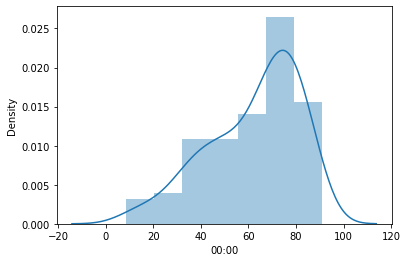

In [16]:
sns.distplot(dfCluster2['00:00'])

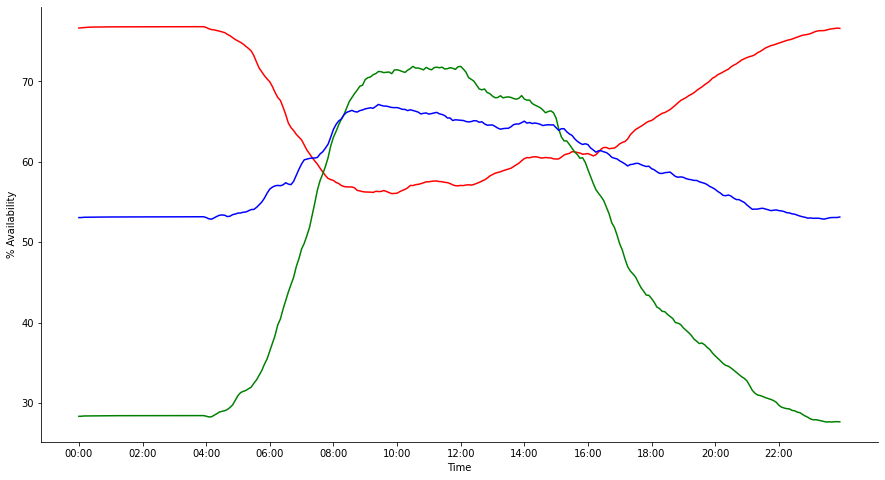

In [17]:
from sklearn.cluster import KMeans

n_clusters = 3

fig, ax = plt.subplots(figsize=(15,8))
colours = ['red','green','blue']


kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(dfCluster2)
cluster_labels = kmeans.labels_
#weekday_avg = weekday_avg.assign(CLUSTER = cluster_labels)
for k, colour in zip(kmeans.cluster_centers_, colours):
    plt.plot(k,color=colour,label=colour)
    plt.plot()

xticks = ax.get_xticks()
xticks = range(0,288,24)
new_ticks = [times[i] for i in [int(_) for _ in xticks]]
plt.xticks(xticks, new_ticks, rotation='horizontal')
plt.xlabel('Time')
plt.ylabel("% Availability")
sns.despine()
plt.show()
fig.savefig(f'{images_dir}/Station Availability Cluster Analysis.png')#, bbox_inches='tight')

clusters = kmeans.predict(dfCluster2)

In [19]:
Locations = df[['station_id','name','latitude','longitude']]
Locations = Locations.groupby(['station_id', 'name']).first()
Locations = Locations.reset_index().set_index('name')
Locations['cluster'] = pd.Series(index=dfCluster2.index, data=clusters)
Locations

,station_id,latitude,longitude,cluster
name,,,,
BLESSINGTON STREET,2,53.356770,-6.268140,0
BOLTON STREET,3,53.351181,-6.269859,0
GREEK STREET,4,53.346874,-6.272976,2
CHARLEMONT PLACE,5,53.330662,-6.260177,0
CHRISTCHURCH PLACE,6,53.343369,-6.270120,1
...,...,...,...,...
MERRION SQUARE SOUTH,113,53.338615,-6.248606,2
WILTON TERRACE (PARK),114,53.333652,-6.248345,1
KILLARNEY STREET,115,53.354843,-6.247579,0


In [20]:
Cluster0 = dfCluster2.iloc[clusters==0]
Cluster1 = dfCluster2.iloc[clusters==1]
Cluster2 = dfCluster2.iloc[clusters==2]

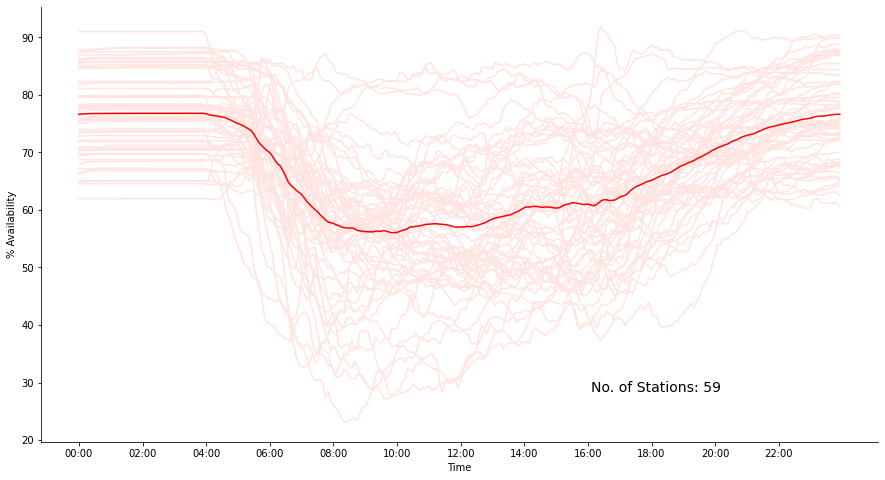

In [21]:
xticks = range(0,288,24)
size0 = Cluster0.shape[0]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(Cluster0.T, color = 'mistyrose' )
ax.plot(kmeans.cluster_centers_[0],color='red')

xticks = ax.get_xticks()
xticks = range(0,288,24)
new_ticks = [times[i] for i in [int(_) for _ in xticks]]
plt.xticks(xticks, new_ticks, rotation='horizontal')
plt.xlabel('Time')
plt.ylabel("% Availability")
sns.despine()
ax.annotate(f"No. of Stations: {size0}",
            xy=(550,50), xycoords='axes points',fontsize=14)


plt.show()
fig.savefig(f'{images_dir}/Cluster0.png')#, bbox_inches='tight')

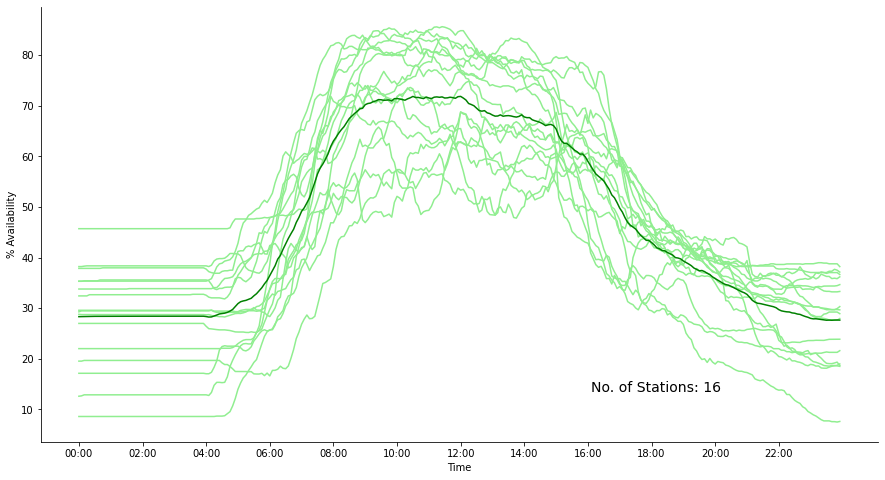

In [22]:
xticks = range(0,288,24)
size1 = Cluster1.shape[0]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(Cluster1.T, color = 'lightgreen' )
ax.plot(kmeans.cluster_centers_[1],color='green')


xticks = ax.get_xticks()
xticks = range(0,288,24)
new_ticks = [times[i] for i in [int(_) for _ in xticks]]
plt.xticks(xticks, new_ticks, rotation='horizontal')
plt.xlabel('Time')
plt.ylabel("% Availability")
sns.despine()
ax.annotate(f"No. of Stations: {size1}",
            xy=(550,50), xycoords='axes points',fontsize=14)


plt.show()
fig.savefig(f'{images_dir}/Cluster1.png')#, bbox_inches='tight')


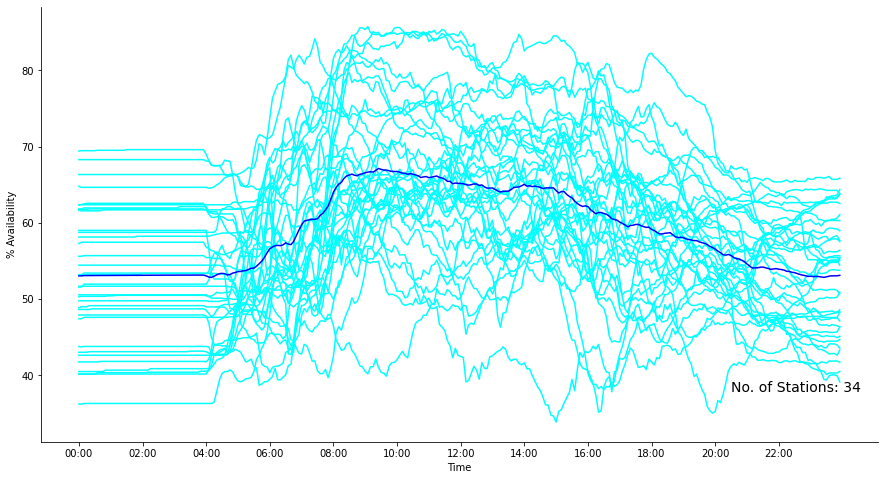

In [23]:
xticks = range(0,288,24)
size2 = Cluster2.shape[0]
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(Cluster2.T, color = 'aqua')
ax.plot(kmeans.cluster_centers_[2],color='blue')


xticks = ax.get_xticks()
xticks = range(0,288,24)
new_ticks = [times[i] for i in [int(_) for _ in xticks]]
plt.xticks(xticks, new_ticks, rotation='horizontal')
plt.xlabel('Time')
plt.ylabel("% Availability")
sns.despine()
ax.annotate(f"No. of Stations: {size2}",
            xy=(690,50), xycoords='axes points',fontsize=14)


plt.show()
fig.savefig(f'{images_dir}/Cluster2.png')#, bbox_inches='tight')

In [27]:
import folium
mp = folium.Map(location=[53.35, -6.2603], zoom_start=14.4,tiles='cartodbpositron')
for c , colour in zip(range(n_clusters),colours):
    tmp = Locations[Locations['cluster'] == c]
 
    for location in tmp.iterrows():
            folium.CircleMarker(
                location=[location[1]['latitude'],location[1]['longitude']],
                radius=12,
                popup=location[0],
                color=colour,
                fill_color=colour
            ).add_to(mp)

mp.save(f'{images_dir}/map.html')
mp

In [29]:
print_summary_statistics(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2887955 entries, 0 to 2887954
Data columns (total 19 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   time                            object 
 1   station_id                      int32  
 2   name                            object 
 3   bike_stands                     float64
 4   available_bike_stands           float64
 5   available_bikes_at_station      float64
 6   address                         object 
 7   latitude                        float64
 8   longitude                       float64
 9   rain                            float64
 10  temp                            float64
 11  decomissioned                   float64
 12  available_bikes_max             float64
 13  available_bikes                 float64
 14  active_bikes                    float64
 15  available_bikes_at_station_max  float64
 16  station_availability            float64
 17  rainy_day?                 

In [30]:
print_weather_summary(df)

AttributeError: ignored

In [ ]:
import requests
address = '24 Leinster Road, Dublin'
geo_url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}'.format(address)
response = requests.get(geo_url)
results = response.json()
if len(results['results']) == 0:
        output = {
            "formatted_address" : None,
            "latitude": None,
            "longitude": None,
            "accuracy": None,
            "google_place_id": None,
            "type": None,
            "postcode": None
        }
else:    
    answer = results['results'][0]
    output = {
        "formatted_address" : answer.get('formatted_address'),
        "latitude": answer.get('geometry').get('location').get('lat'),
        "longitude": answer.get('geometry').get('location').get('lng'),
        "accuracy": answer.get('geometry').get('location_type'),
        "google_place_id": answer.get("place_id"),
        "type": ",".join(answer.get('types')),
        "postcode": ",".join([x['long_name'] for x in answer.get('address_components') 
                              if 'postal_code' in x.get('types')])
        }

# Append some other details:    
output['input_string'] = address
output['number_of_results'] = len(results['results'])
output['status'] = results.get('status')

output['response'] = results

print(output)

{'formatted_address': None, 'latitude': None, 'longitude': None, 'accuracy': None, 'google_place_id': None, 'type': None, 'postcode': None, 'input_string': '24 Leinster Road, Dublin', 'number_of_results': 0, 'status': 'REQUEST_DENIED', 'response': {'error_message': 'You must use an API key to authenticate each request to Google Maps Platform APIs. For additional information, please refer to http://g.co/dev/maps-no-account', 'results': [], 'status': 'REQUEST_DENIED'}}


In [ ]:
store_data_in_sql(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


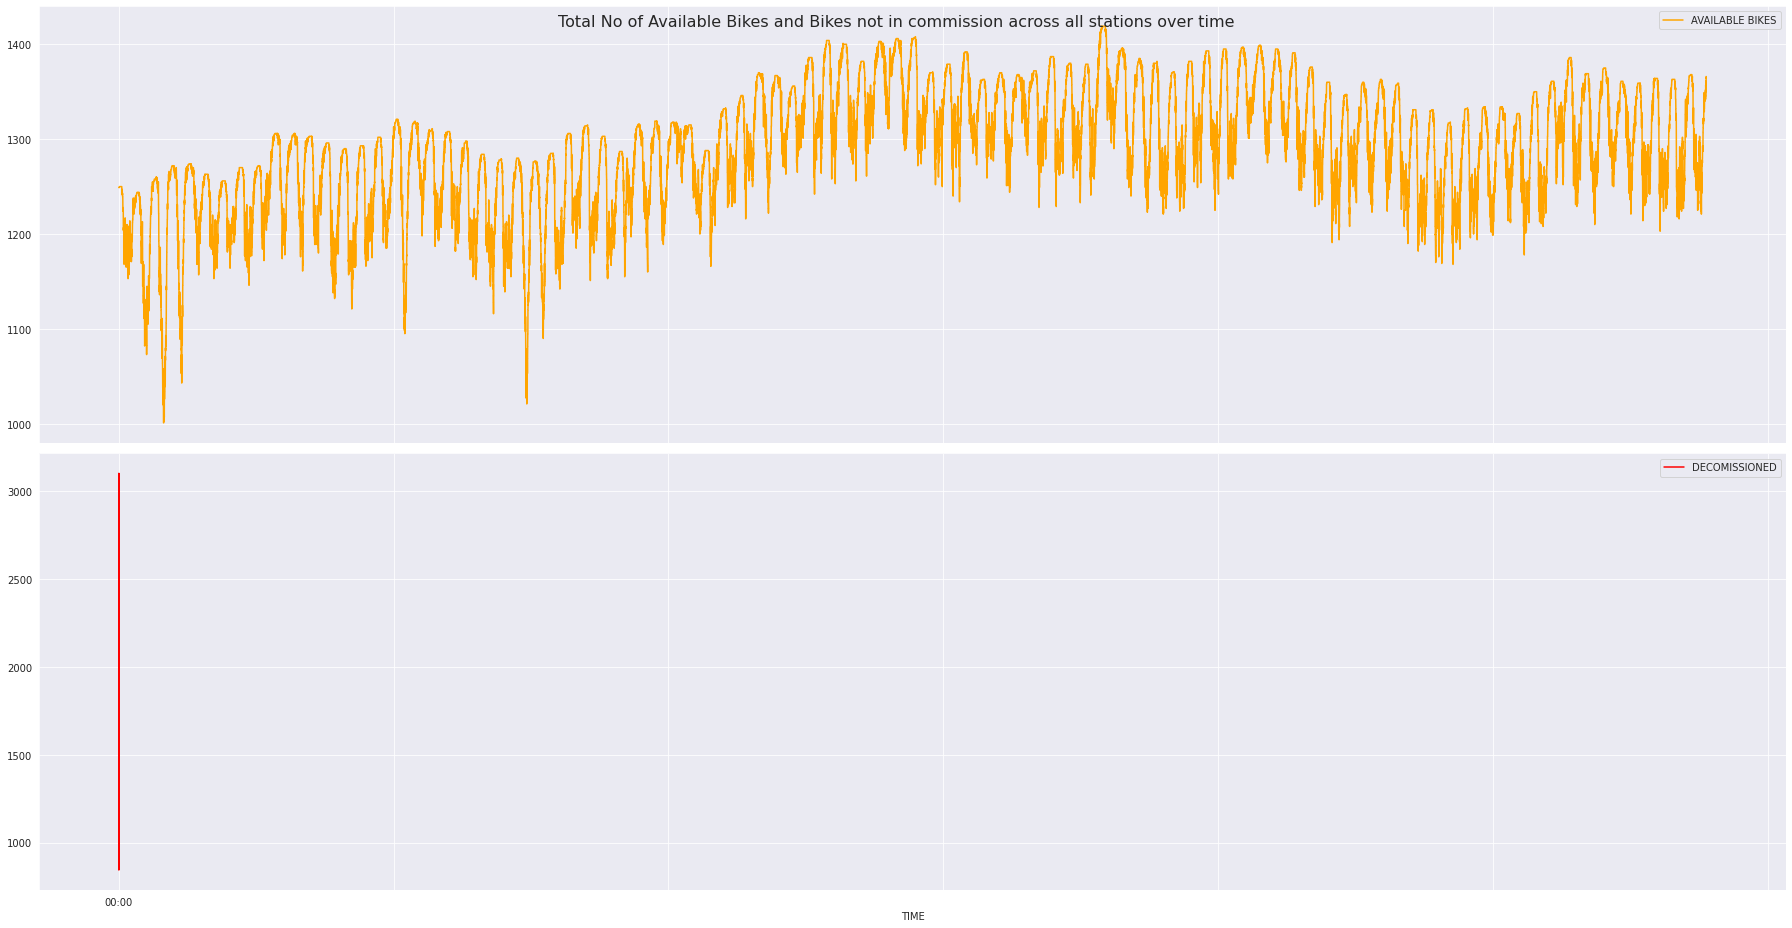

In [ ]:


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig.suptitle('Total No of Available Bikes and Bikes not in commission across all stations over time', fontsize=16)
#ax1.set_ylim([1000,1500])
decomisisoned_daily = df[['STATION ID','TIME','DECOMISSIONED']].groupby('TIME').sum().reset_index()

#active_bikes = active_bikes.resample('H').first()
df.plot('TIME','AVAILABLE BIKES', ax = ax1,color = 'orange')
decomisisoned_daily.plot('TIME', 'DECOMISSIONED', ax = ax2, color = 'red')
plt.show()




TypeError: ignored

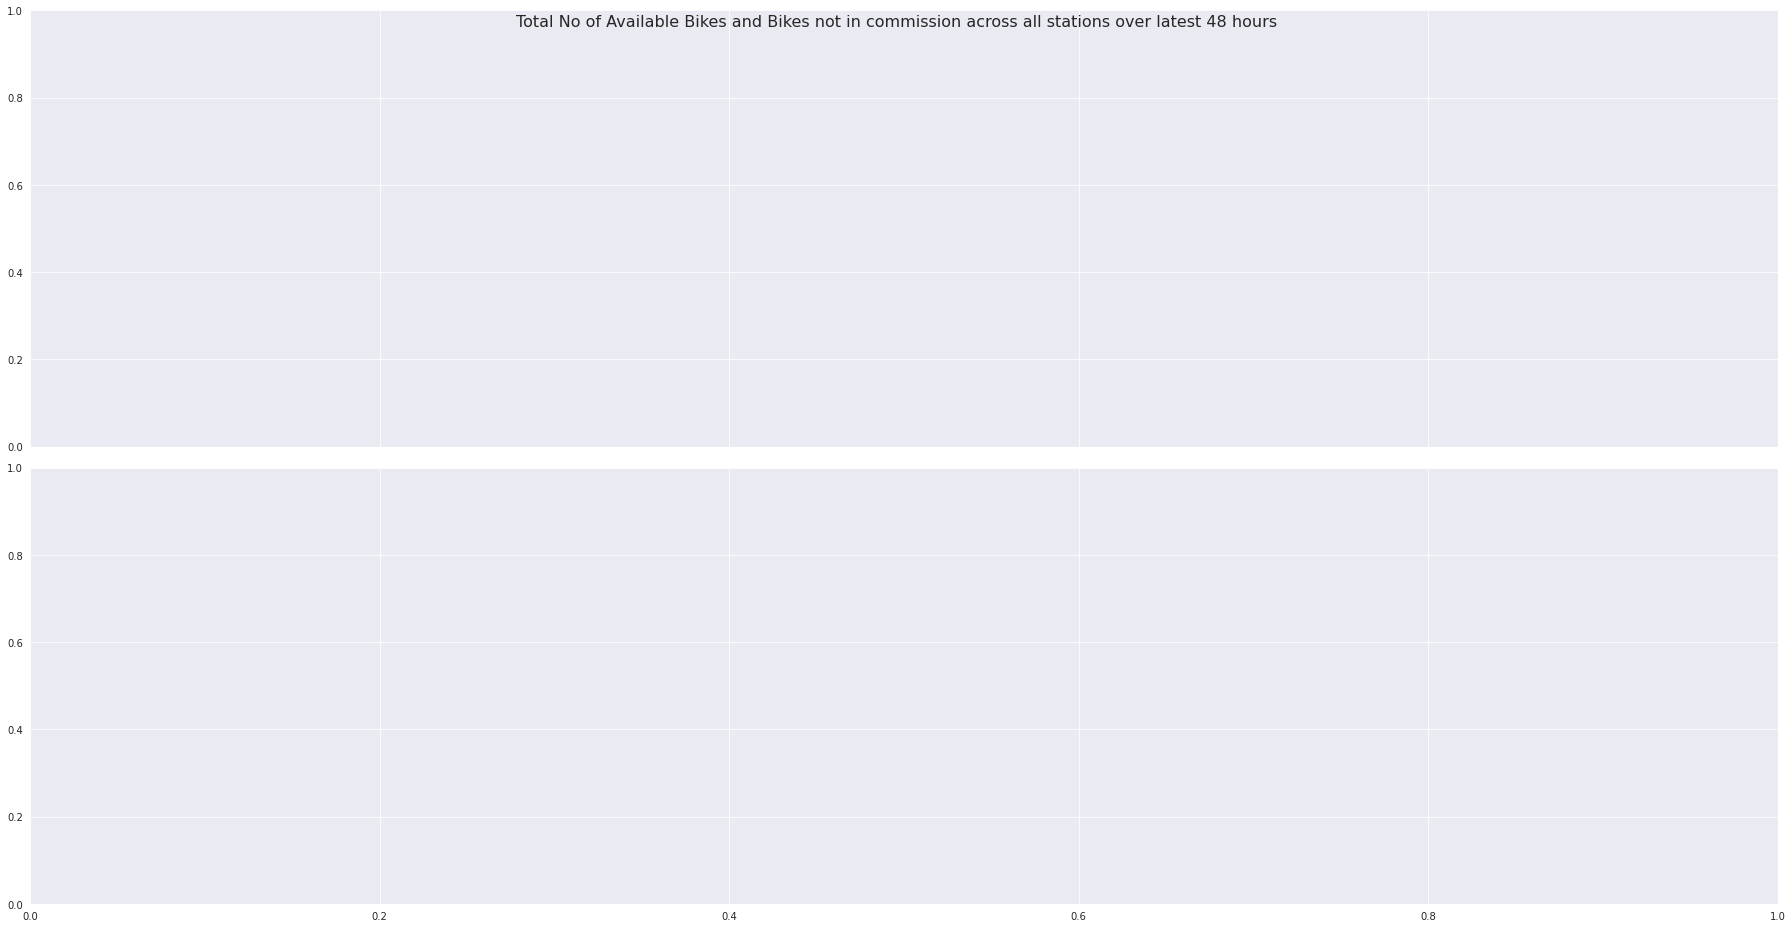

In [ ]:
# Looking at the variability in available bikes across a dya
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig2, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig2.suptitle('Total No of Available Bikes and Bikes not in commission across all stations over latest 48 hours', fontsize=16)

df_latest48 = subset_df_by_start_end_date(df,'2021-03-30 00:01:00') 
decomisisoned_daily = df_latest48[['STATION ID','TIME','DECOMISSIONED']].groupby('TIME').sum().reset_index()
#ax1.set_ylim([1200,1400])

df_latest48.plot('TIME','AVAILABLE BIKES', ax = ax1,color = 'deeppink')
decomisisoned_daily.plot('TIME', 'DECOMISSIONED', ax = ax2, color = 'green')
plt.show()



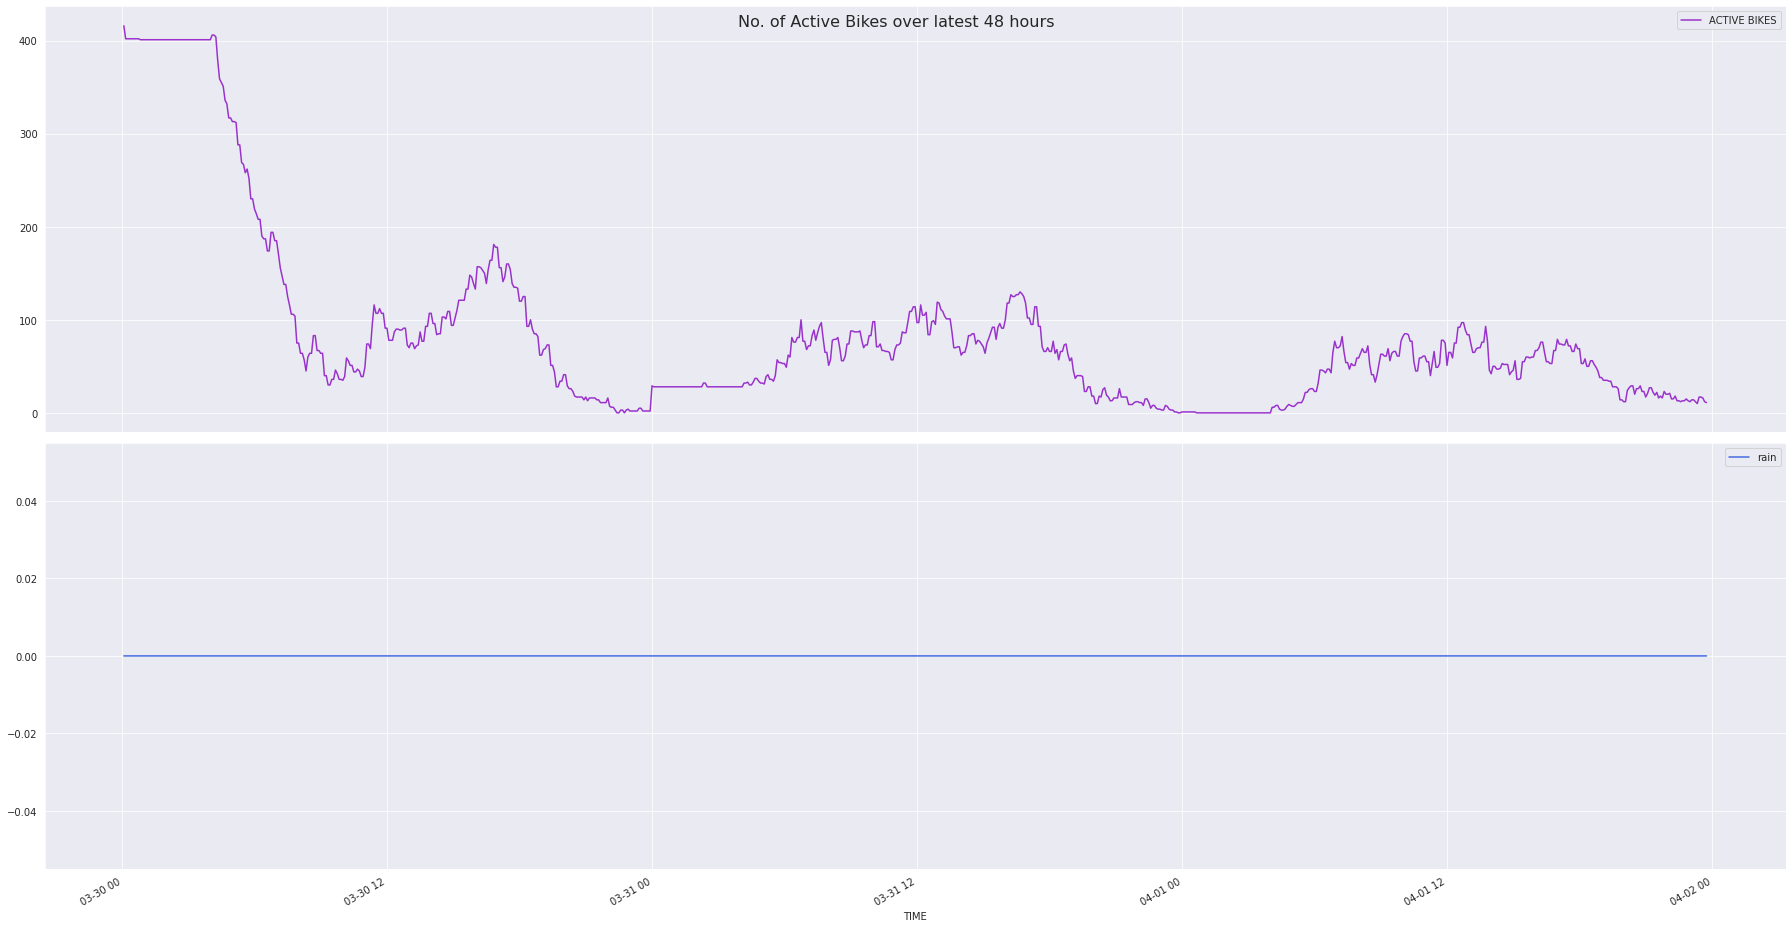

In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('No. of Active Bikes over latest 48 hours', fontsize=16)

last48hrs = subset_df_by_start_end_date(df,'2021-03-30 00:01:00')

last48hrs.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
last48hrs.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


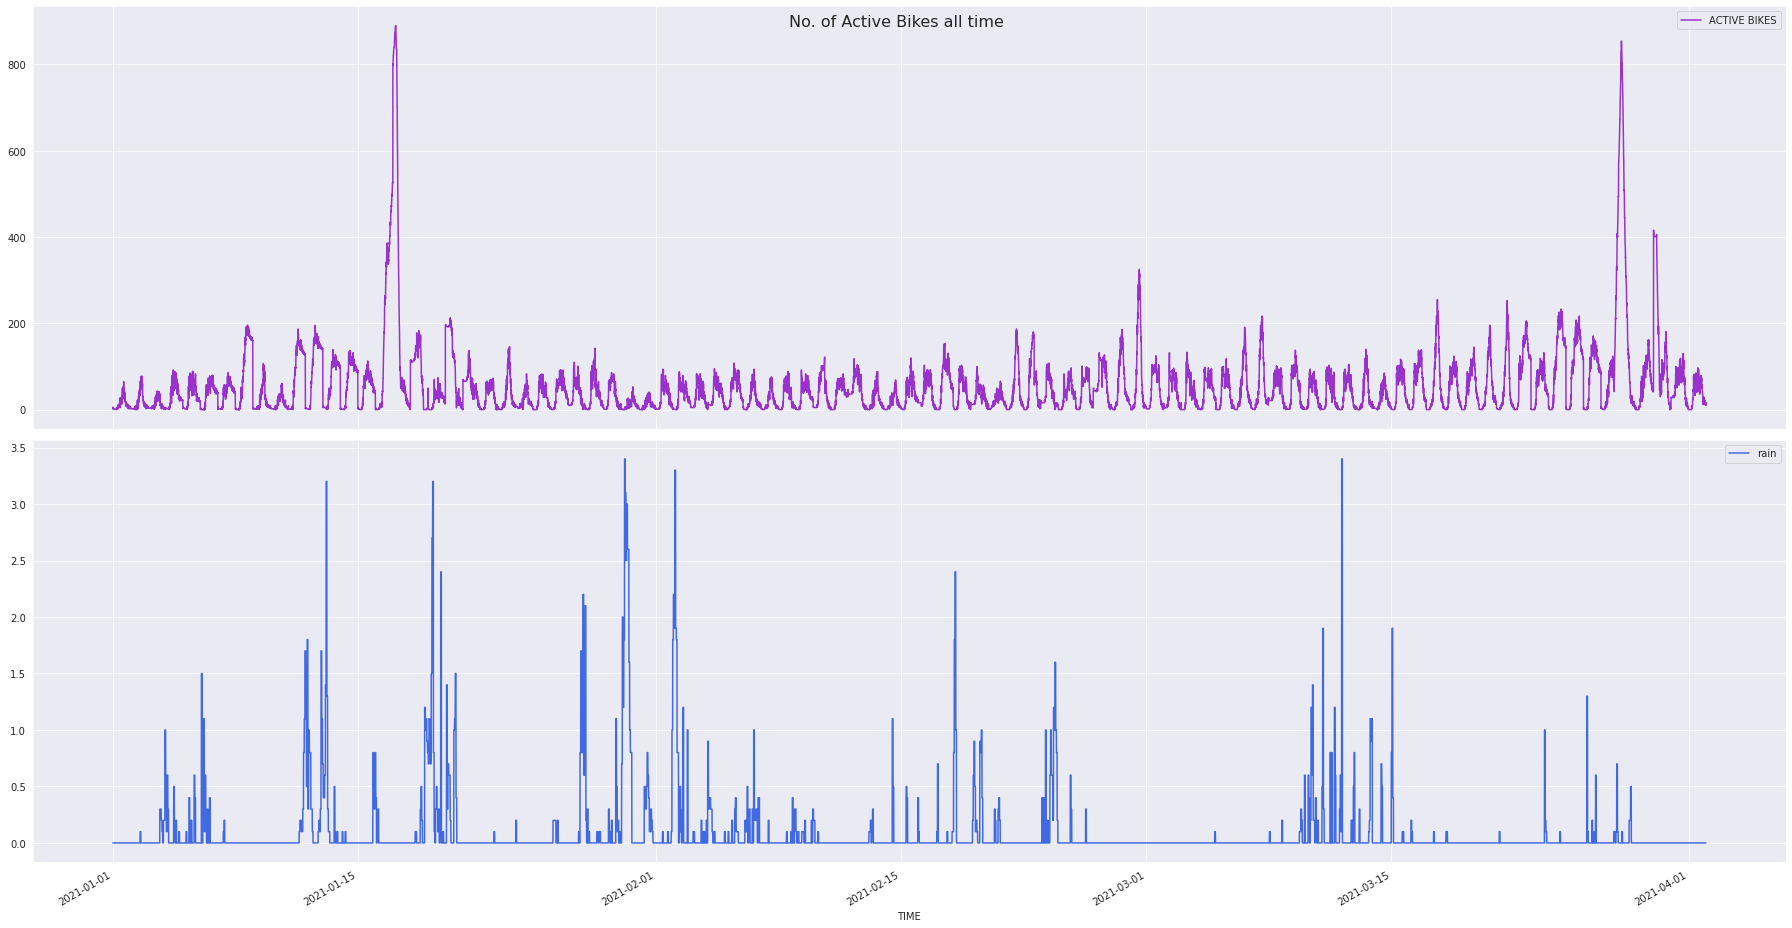

In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('No. of Active Bikes all time', fontsize=16)

#df = read_from_sql('SELECT TIME, "ACTIVE BIKES",rain FROM Bike_data')

df.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
df.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


In [ ]:
df['AC'].max()

1266.0

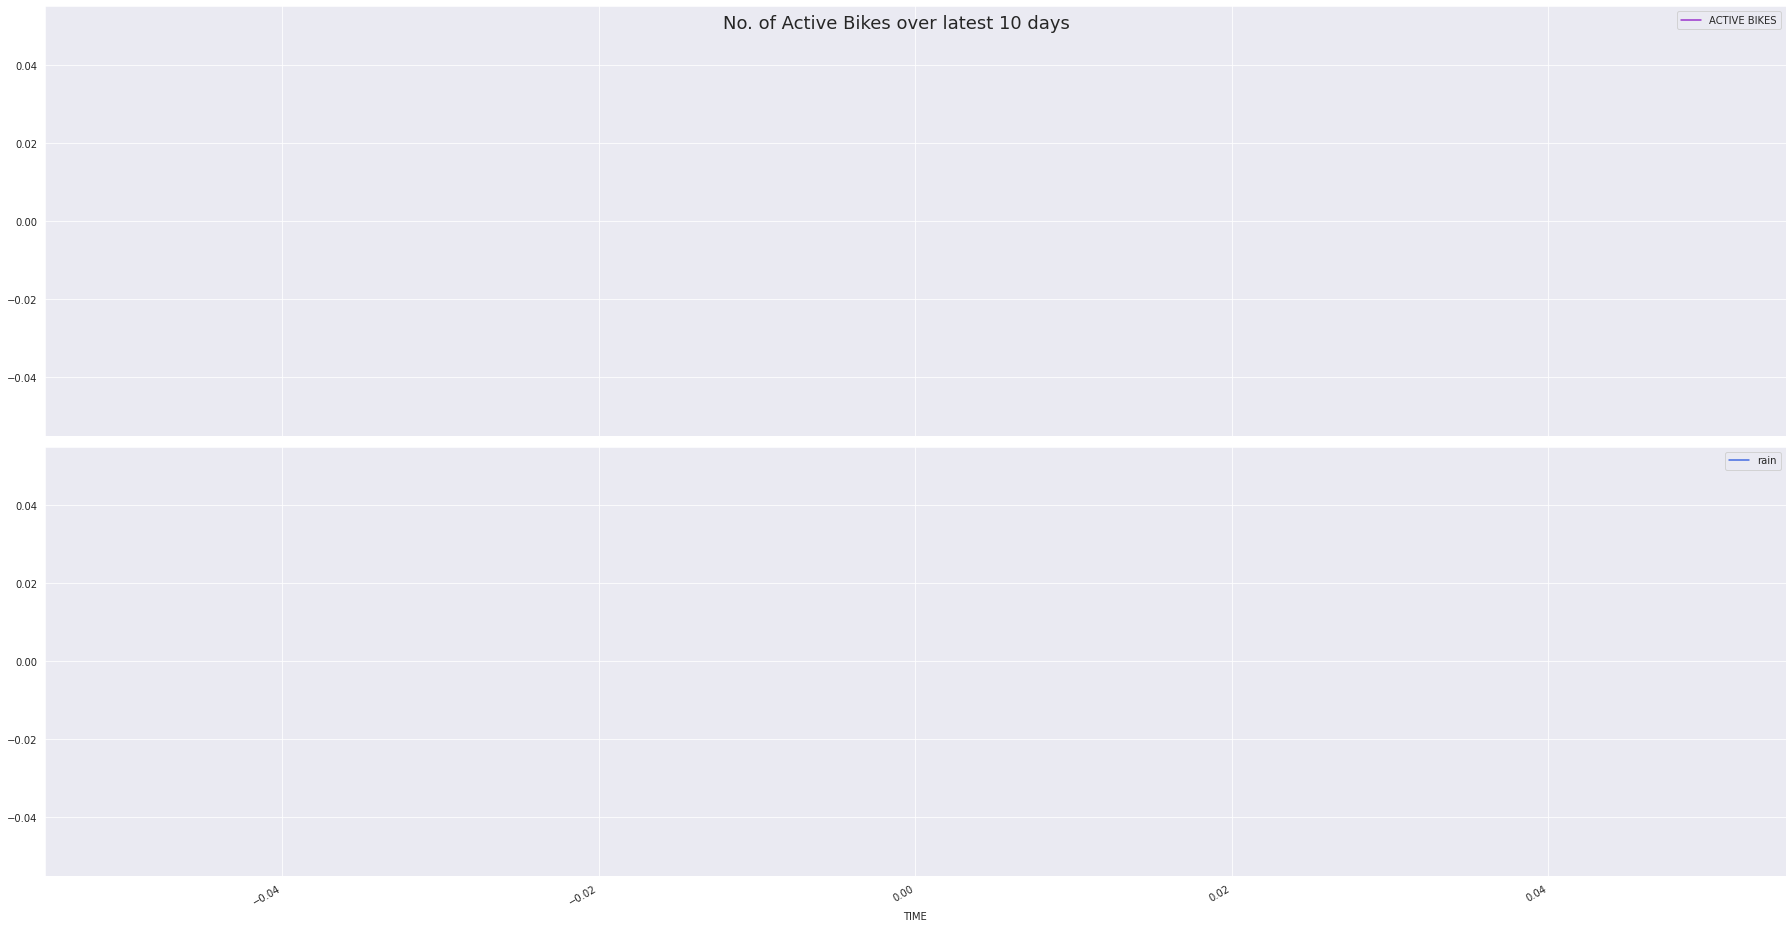

In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig5, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig5.suptitle('No. of Active Bikes over latest 10 days', fontsize=18)

last10days = subset_df_by_start_end_date(df,'2021-06-21 00:01:00')

last10days.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
last10days.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


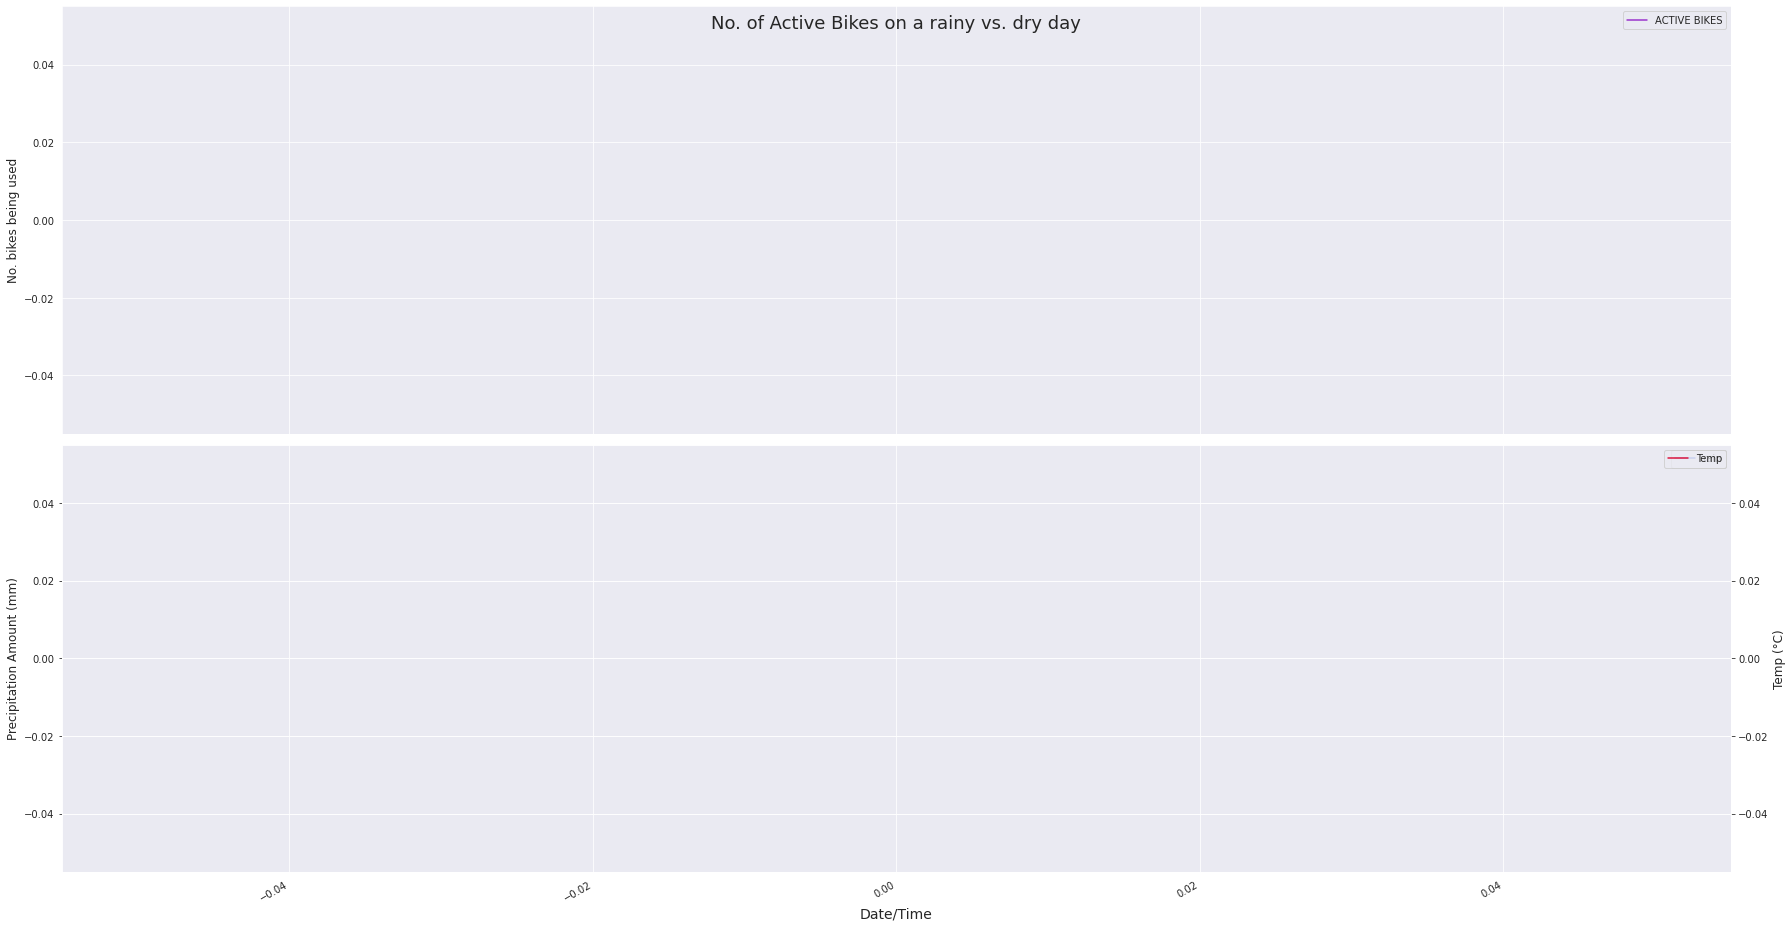

In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig6, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig6.suptitle('No. of Active Bikes on a rainy vs. dry day', fontsize=18)

rainy_period = subset_df_by_start_end_date(df,'2021-06-22 00:01:00','2021-06-25 00:01:00')                                      

#ax1.set_ylim([1200,1400])

rainy_period.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_period.plot('TIME','rain', ax = ax2, color = 'royalblue')
ax3 = ax2.twinx()
rainy_period.plot('TIME','temp', ax = ax3, color = 'crimson', label = 'Temp')

ax2.set_xlabel('Date/Time', fontsize = 14)
ax1.set_ylabel('No. bikes being used', fontsize = 12)
ax2.set_ylabel('Precipitation Amount (mm)', fontsize = 12)
ax3.set_ylabel('Temp (°C)', fontsize = 12)
plt.show()


In [ ]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig8, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig8.suptitle('No. of Active Bikes over 9 days in June vs Weather', fontsize=16)

rainy_days_june = subset_df_by_start_end_date(df,'2021-05-14 00:01:00', '2021-05-23 00:01:00') 

#ax1.set_ylim([1200,1400])

rainy_days_june.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_days_june.plot('TIME','rain', ax = ax2, color = 'royalblue', label = 'Rain')
ax3 = ax2.twinx()
rainy_days_june.plot('TIME','temp', ax = ax3, color = 'crimson', label = 'Temp')

ax2.set_xlabel('Date/Time', fontsize = 14)
ax1.set_ylabel('No. bikes being used', fontsize = 12)
ax2.set_ylabel('Precipitation Amount (mm)', fontsize = 12)
ax3.set_ylabel('Temp (°C)', fontsize = 12)
plt.show()

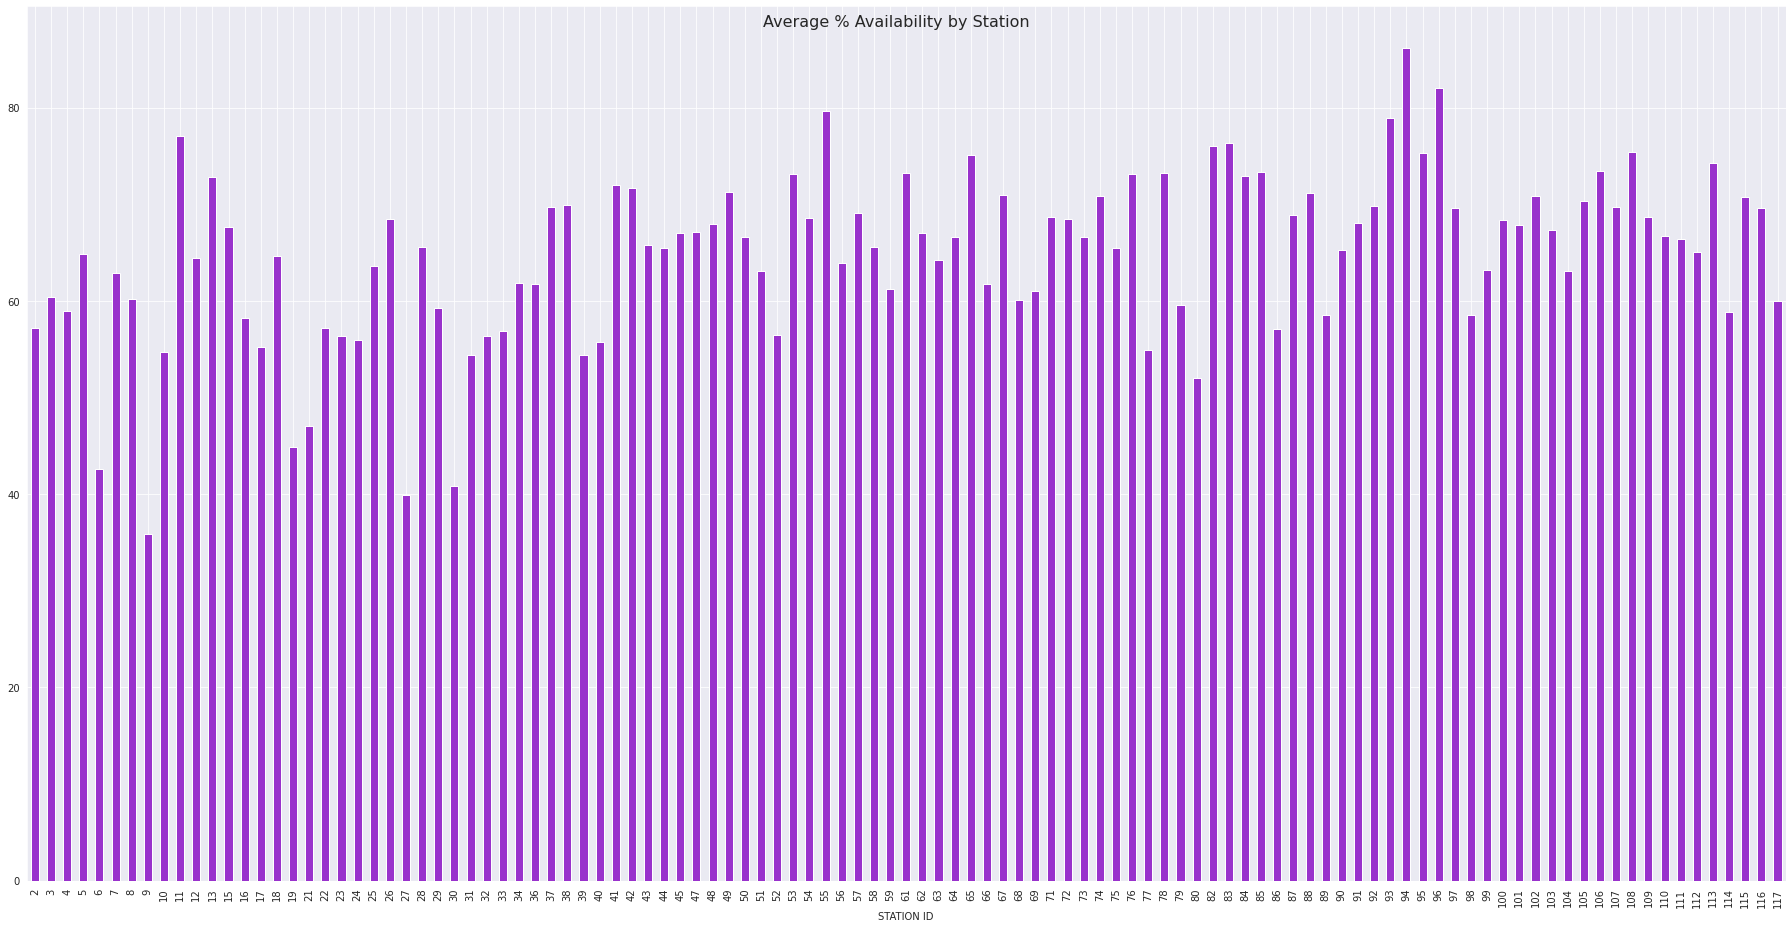

In [ ]:
Avg_Station_Availability = df.groupby('STATION ID')['STATION AVAILABILITY'].mean()

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, ax = plt.subplots( figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('Average % Availability by Station', fontsize=16)

#ax1.set_ylim([1200,1400])

Avg_Station_Availability.plot.bar( ax = ax, color = 'darkorchid')
plt.show()


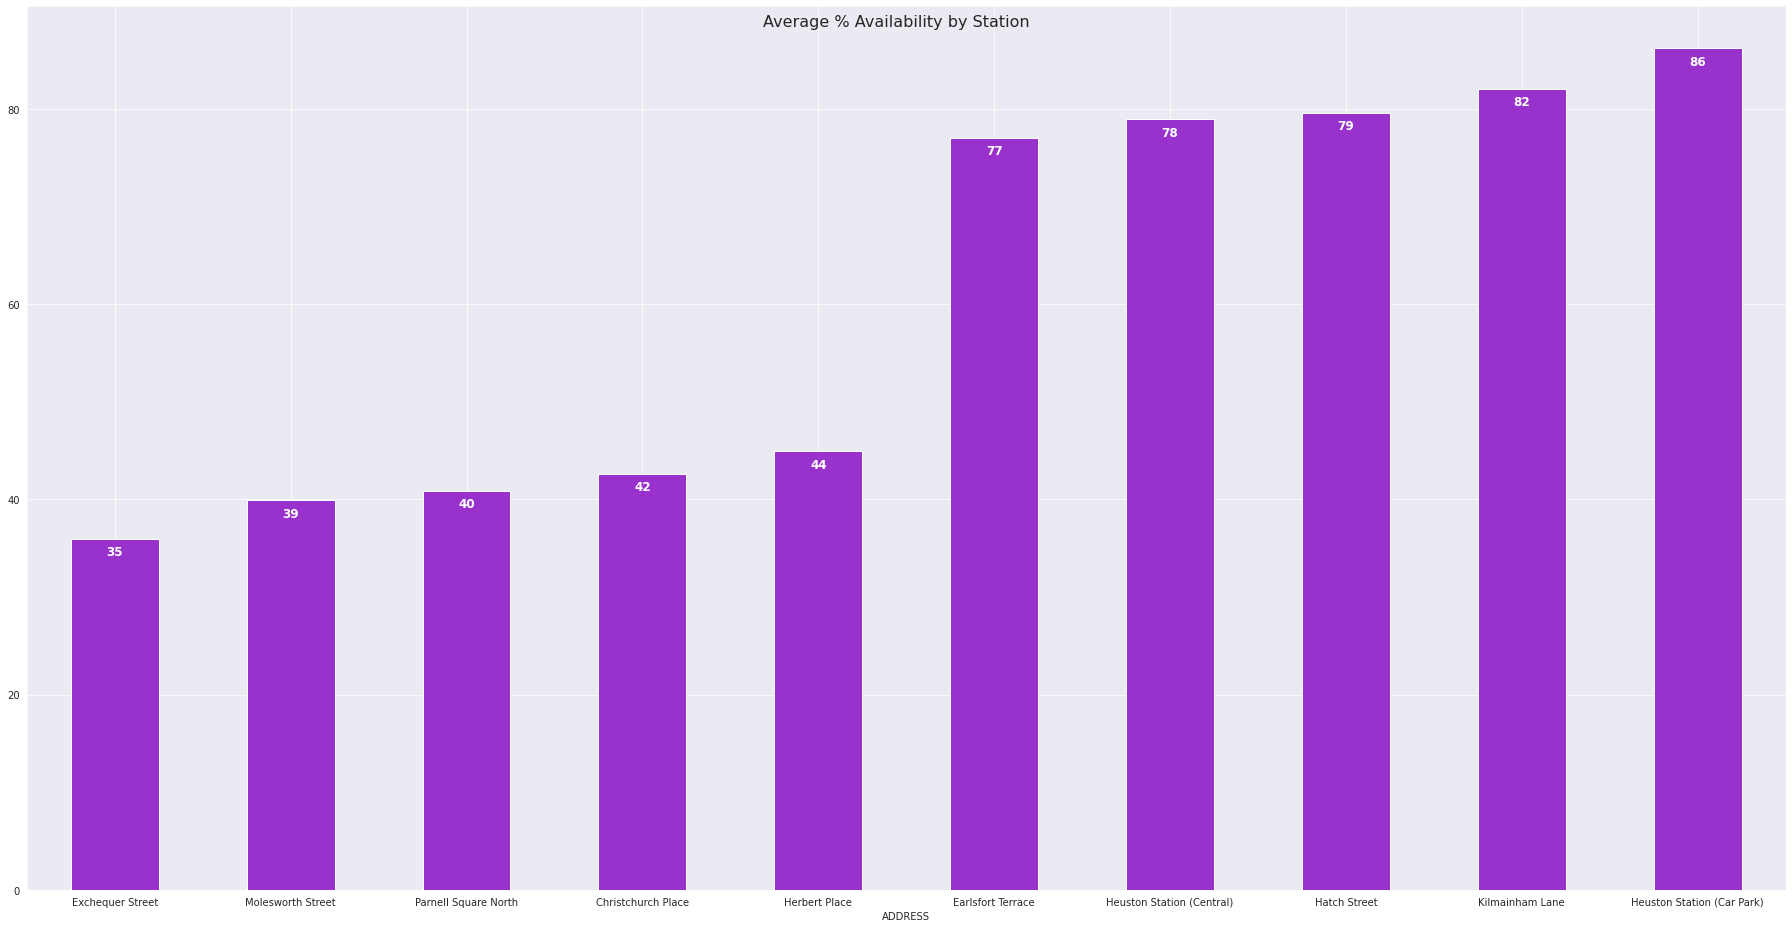

In [ ]:
stationsOfInterest = subset_df_by_stationID(df, [94,93,11,96,55,19,9,30,6,27])

Avg_Station_Availability = stationsOfInterest.groupby('ADDRESS')['STATION AVAILABILITY'].mean().sort_values()

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, ax = plt.subplots( figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('Average % Availability by Station', fontsize=16)
Avg_Station_Availability.plot.bar( ax = ax, color = 'darkorchid')
plt.xticks(rotation=0)
rects = ax.patches

# Make some labels.
labels = Avg_Station_Availability.astype(int)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height - 2, label, ha="center", va="bottom", color='white', fontsize=12, weight = 'bold'
    )
plt.show()

In [ ]:
Avg_Station_Availability = df.groupby('ADDRESS')['STATION AVAILABILITY'].mean().sort_values()

In [ ]:
ActivityByDay = df.groupby([df['TIME'].dt.day_name(),'TIME'])['ACTIVE BIKES'].mean()
ActivityByDay.index.names=['Day of Week','TIME']
Mon = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Monday'].droplevel(0))

In [ ]:
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over Monday 28th June 2021', fontsize=16)
Mon = Mon.reset_index()
Mon['TIME'] = pd.to_datetime(Mon['TIME'])
Mon['date'] = Mon['TIME'].dt.date
Mon['TIME'] = Mon['TIME'].dt.time
Mon = Mon[Mon['date'] == Mon['date'].max()]
Mon.plot( ax = ax, color = 'darkorchid')

In [ ]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over Week beginning 28/06/2021 by day of week', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day[day['date'] == day['date'].max()]
  day.plot(x= 'TIME', ax = ax)


In [ ]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over Week beginning 28/06/2021 by day of week', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').median()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day[day['date'] == day['date'].max()]
  day.plot(x= 'TIME', ax = ax)



In [ ]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig12,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig12.suptitle('Average No. of Active Dublin Bikes by day of week', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').mean()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day.groupby('TIME').mean()
  day.plot( ax = ax)


In [ ]:
rainyDays = df[df['rainy day']==True]
dryDays = df[df['rainy day']==False]
print('Proportion of rainy days = \n ', rainyDays.shape[0]/(rainyDays.shape[0]+dryDays.shape[0]))

In [ ]:
DryDaysbyWeekday = get_activity_by_day(dryDays)

daysofweek = list(DryDaysbyWeekday.index.get_level_values(0).unique())
fig12,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig12.suptitle('Average No. of Active Dublin Bikes by day of week (dry days only)', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(DryDaysbyWeekday.iloc[DryDaysbyWeekday.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').mean()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day.groupby('TIME').mean()
  day.plot( ax = ax)

In [ ]:
ROI_map.plot()

In [ ]:
import folium
Geo_Station_Availability = df[['NAME','STATION ID','LATITUDE','LONGITUDE','STATION AVAILABILITY']].groupby('STATION ID').agg({'NAME':'first','STATION ID':'first', 'STATION AVAILABILITY':'mean', 'LATITUDE':'first', 'LONGITUDE':'first'}).sort_values(by='STATION AVAILABILITY', ascending = False).reset_index(drop=True)
Geo_Station_Availability.sort_values('STATION AVAILABILITY', inplace=True)
Geo_Station_Availability['bin'] = pd.qcut(Geo_Station_Availability['STATION AVAILABILITY'],q=3, precision=0)
Geo_bins_grouped = Geo_Station_Availability.groupby('bin')
Geo_bins_grouped = [Geo_bins_grouped.get_group(x) for x in group.groups]
lowAvailability = Geo_bins_grouped[0]
MediumAvailability = Geo_bins_grouped[1]
HighAvailability = Geo_bins_grouped[2]

print(lowAvailability)

map = folium.Map(location=[Geo_Station_Availability.LATITUDE.mean(), Geo_Station_Availability.LONGITUDE.mean()], zoom_start=14, control_scale=True)

for index, locations in lowAvailability.iterrows():
    folium.Marker([locations["LATITUDE"], locations["LONGITUDE"]], popup=folium.Popup(locations["NAME"]),icon=folium.Icon(icon="cloud",color='red')).add_to(map)

for index, locations in MediumAvailability.iterrows():
    folium.Marker([locations["LATITUDE"], locations["LONGITUDE"]], popup=folium.Popup(locations["NAME"]),icon=folium.Icon(icon="cloud",color='blue')).add_to(map)

for index, locations in HighAvailability.iterrows():
    folium.Marker([locations["LATITUDE"], locations["LONGITUDE"]], popup=folium.Popup(locations["NAME"]),icon=folium.Icon(icon="cloud",color='green')).add_to(map)

map

NameError: ignored

In [ ]:
import folium
mp = folium.Map(location=[53.34, -6.2603], zoom_start=14,tiles='cartodbpositron')
for c , colour in zip(range(n_clusters),colours):
    tmp = Locations[Locations['Cluster'] == c]
 
    for location in tmp.iterrows():
            folium.CircleMarker(
                location=[location[1]['LATITUDE'],location[1]['LONGITUDE']],
                radius=7,
                popup=location[0],
                color=colour,
                fill_color=colour
            ).add_to(mp)

#mp.save('map.html')
mp

IndexError: ignored